In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [333]:
df = pd.read_csv('pitches_final_simplified.csv', index_col = 0)

C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [334]:
df.columns

Index(['game_date', 'release_speed', 'player_name', 'description', 'zone',
       'type', 'balls', 'strikes', 'plate_x', 'plate_z', 'on_3b', 'on_2b',
       'on_1b', 'outs_when_up', 'inning', 'sz_top', 'sz_bot', 'at_bat_number',
       'pitch_number', 'pitch_name', 'bat_score', 'fld_score', 'reg_season',
       'post_season', 'p_left', 'p_right', 'bat_left', 'bat_right',
       'prev_pitch'],
      dtype='object')

In [29]:
df['game_date'].sort_values()

0          2015-04-05
205        2015-04-05
204        2015-04-05
203        2015-04-05
202        2015-04-05
              ...    
3615228    2019-10-30
3615227    2019-10-30
3615226    2019-10-30
3615233    2019-10-30
3615436    2019-10-30
Name: game_date, Length: 3615437, dtype: object

In [30]:
df.head()

,game_date,release_speed,player_name,description,zone,type,balls,strikes,plate_x,plate_z,...,pitch_name,bat_score,fld_score,reg_season,post_season,p_left,p_right,bat_left,bat_right,prev_pitch
0,2015-04-05,90.1,Adam Wainwright,ball,13,B,0,0,-1.585,1.720,...,Fastball,0,1,1,0,0,1,1,0,None
1,2015-04-05,88.1,Adam Wainwright,hit_into_play_no_out,5,X,1,0,0.008,2.602,...,Fastball,0,1,1,0,0,1,1,0,Fastball
2,2015-04-05,92.2,Adam Wainwright,foul,5,S,0,0,0.015,2.287,...,Fastball,0,1,1,0,0,1,0,1,None
3,2015-04-05,76.6,Adam Wainwright,blocked_ball,14,B,0,1,1.703,0.220,...,Breaking Ball,0,1,1,0,0,1,0,1,Fastball
4,2015-04-05,89.9,Adam Wainwright,hit_into_play,9,X,1,2,0.788,1.808,...,Fastball,0,1,1,0,0,1,0,1,Breaking Ball


In [606]:
kershaw = df[df['player_name']=='Max Scherzer']

In [607]:
# Naturally expect a class imbalance for pitchers
kershaw['pitch_name'].value_counts()

Fastball         9910
Breaking Ball    4758
Off-speed        2389
Name: pitch_name, dtype: int64

In [608]:
# Drop intentional balls and pitch outs, they aren't real pitches and batters don't need to worry about them
kershaw.drop(kershaw[kershaw['pitch_name']=='Intentional Ball'].index, inplace=True, errors = 'ignore')
kershaw.drop(kershaw[kershaw['pitch_name']=='Pitch Out'].index, inplace=True, errors = 'ignore')
kershaw.drop(kershaw[kershaw['pitch_name']=='Other'].index, inplace=True, errors = 'ignore')

# Unable to classify/do regression with classes with only 1 instance
# so drop the rows with that pitch as well as the row w/ corresponding 'prev_pitch'
for i in range(len(kershaw['pitch_name'].value_counts())):
    if kershaw['pitch_name'].value_counts()[i] == 1:
        drop = kershaw['pitch_name'].value_counts().index[i]
        kershaw.drop(kershaw[kershaw['pitch_name']==drop].index, inplace=True)
        kershaw.drop(kershaw[kershaw['prev_pitch']==drop].index, inplace=True)

kershaw.drop(['game_date', 'description'], axis = 1, inplace = True)

# Don't need pitcher handedness in this, the variance of the columns will be 0
kershaw.drop(['p_left', 'p_right'], axis = 1, inplace = True)

# Drop release_speed since this isn't a predicative feature for guessing pitches prior to the pitch being thrown
kershaw.drop(['release_speed'], axis = 1, inplace = True)

# Drop other non pre-pitch predicative stuff
kershaw.drop(['type', 'plate_x', 'plate_z'], axis = 1, inplace = True)

kershaw.drop(['player_name', 'at_bat_number'], axis = 1, inplace = True)

balls = pd.get_dummies(kershaw['balls'], prefix = 'b_')

strikes = pd.get_dummies(kershaw['strikes'], prefix = 's_')

prev = pd.get_dummies(kershaw['prev_pitch'], prefix= 'prev_')

outs = pd.get_dummies(kershaw['outs_when_up'], prefix = 'o_')

X = pd.concat([kershaw, balls, strikes, outs, prev], axis = 1)

# Drop the original columns
X.drop(['balls', 'strikes', 'outs_when_up', 'prev_pitch'], axis = 1, inplace = True)

# X.drop(['pitch_name'], axis = 1, inplace = True)

X.drop(['sz_top', 'sz_bot'], axis = 1, inplace = True)

X['early'] = np.where(X['inning'] <= 3, 1, 0)
X['mid'] = np.where((X['inning'] <= 6) & (X['inning'] > 3), 1, 0)
X['late'] = np.where((X['inning'] <= 9) & (X['inning'] > 6), 1, 0)

X.drop(['inning'], axis = 1, inplace = True)

X.drop(['pitch_number'], axis = 1, inplace = True)

X.drop(['zone'], axis = 1, inplace = True)

C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [609]:
X1 = X.drop(['pitch_name'], axis = 1)
y = X['pitch_name']

In [610]:
from sklearn.model_selection import train_test_split

# Split with stratification given the class imbalance
X_train, X_test, y_train, y_test = train_test_split(X1, y, stratify = y, test_size=0.25, random_state=123)
y_test_copy = y_test.copy()

In [611]:
train = pd.concat([X_train, y_train], axis =1)

In [612]:
df_major =  train[train['pitch_name']==train['pitch_name'].value_counts().index[0]]
df_rest = train[train['pitch_name']!=train['pitch_name'].value_counts().index[0]]

df_down = resample(df_major, 
                      replace=True, 
                      n_samples = train['pitch_name'].value_counts().values[1], 
                      random_state=123)


df_downsampled = pd.concat([df_down, df_rest])

In [613]:
df_downsampled.columns

Index(['on_3b', 'on_2b', 'on_1b', 'bat_score', 'fld_score', 'reg_season',
       'post_season', 'bat_left', 'bat_right', 'b__0', 'b__1', 'b__2', 'b__3',
       's__0', 's__1', 's__2', 'o__0', 'o__1', 'o__2', 'prev__Breaking Ball',
       'prev__Fastball', 'prev__None', 'prev__Off-speed', 'early', 'mid',
       'late', 'pitch_name'],
      dtype='object')

In [614]:
X_train = df_downsampled.drop(['pitch_name'], axis = 1)

In [615]:
X_train.columns

Index(['on_3b', 'on_2b', 'on_1b', 'bat_score', 'fld_score', 'reg_season',
       'post_season', 'bat_left', 'bat_right', 'b__0', 'b__1', 'b__2', 'b__3',
       's__0', 's__1', 's__2', 'o__0', 'o__1', 'o__2', 'prev__Breaking Ball',
       'prev__Fastball', 'prev__None', 'prev__Off-speed', 'early', 'mid',
       'late'],
      dtype='object')

In [616]:
y_test.value_counts()

Fastball         2478
Breaking Ball    1190
Off-speed         597
Name: pitch_name, dtype: int64

In [617]:
y_train = df_downsampled['pitch_name']
y_train.value_counts()

Fastball         3568
Breaking Ball    3568
Off-speed        1792
Name: pitch_name, dtype: int64

In [618]:
# Convert output to an array
pitch = pd.get_dummies(y_train.copy())
y_train = pitch.values

In [619]:
pitch = pd.get_dummies(y_test.copy())
y_test = pitch.values

In [620]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8928, 26)
(8928, 3)
(4265, 26)
(4265, 3)


In [395]:
#opt = tf.keras.optimizers.SGD(lr=0.001, momentum = 0.9, nesterov = False)

In [71]:
# Best performing one so far
opt = tf.keras.optimizers.Adam(lr=0.0001)

***

## Optimize epochs

In [527]:
# See how the # of epochs affect accuracy
testacc = []
testloss = []
eps = np.arange(1, 76)
for i in eps:
    # Reset model every time or it will continue to run further epochs on same model
    input_layer = Input(shape = (X_train.shape[1], ))
    dense_layer_1 = Dense(512, activation='relu')(input_layer)
    drop_layer_1 = tf.keras.layers.Dropout(.2)(dense_layer_1)
    dense_layer_2 = Dense(128, activation='relu')(drop_layer_1)
    drop_layer_2 = tf.keras.layers.Dropout(.2)(dense_layer_2)
    dense_layer_3 = Dense(128, activation='relu')(drop_layer_2)
    drop_layer_3 = tf.keras.layers.Dropout(.2)(dense_layer_3)
    dense_layer_4 = Dense(64, activation='relu')(drop_layer_3)
    # Output shape equals to number of classes (columns) in y
    output = Dense(y_train.shape[1], activation='softmax')(dense_layer_4)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

    history = model.fit(X_train, y_train, batch_size=25, epochs=i, verbose=0, validation_split=0.2)
    score = model.evaluate(X_test, y_test, verbose=1)
    testloss.append(score[0])
    testacc.append(score[1])

121/121 [==============================] - 0s 1ms/step - loss: 1.0481 - acc: 0.4420


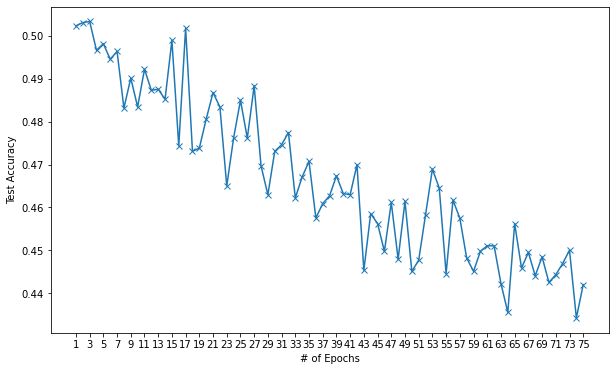

In [528]:
# Acc seems to peak at 17 epochs
plt.figure(figsize = (10,6))
plt.plot(eps, testacc, marker = 'x')
plt.xticks(np.arange(1, 76, 2))
plt.xlabel('# of Epochs')
plt.ylabel('Test Accuracy')
plt.show()

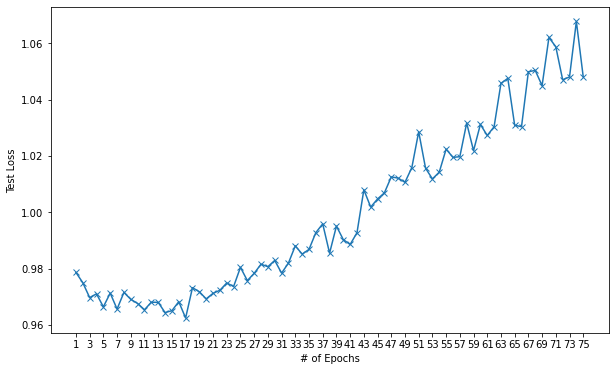

In [529]:
# Loss also bottoms at 17 epochs
plt.figure(figsize = (10,6))
plt.plot(eps, testloss, marker = 'x')
plt.xticks(np.arange(1, 76, 2))
plt.xlabel('# of Epochs')
plt.ylabel('Test Loss')
plt.show()

***

In [621]:
# Make sure to reset model before running each time
input_layer = Input(shape = (X_train.shape[1], ))
dense_layer_1 = Dense(512, activation='relu')(input_layer)
drop_layer_1 = tf.keras.layers.Dropout(.2)(dense_layer_1)
dense_layer_2 = Dense(128, activation='relu')(drop_layer_1)
drop_layer_2 = tf.keras.layers.Dropout(.2)(dense_layer_2)
dense_layer_3 = Dense(128, activation='relu')(drop_layer_2)
drop_layer_3 = tf.keras.layers.Dropout(.2)(dense_layer_3)
dense_layer_4 = Dense(64, activation='relu')(drop_layer_3)
# Output shape equals to number of classes (columns) in y
output = Dense(y_train.shape[1], activation='softmax')(dense_layer_4)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

history = model.fit(X_train, y_train, batch_size=25, epochs=17, verbose=1, validation_split=0.2)

Epoch 1/17
286/286 [==============================] - 1s 4ms/step - loss: 0.9716 - acc: 0.5148 - val_loss: 1.1796 - val_acc: 0.3858
Epoch 2/17
286/286 [==============================] - 1s 3ms/step - loss: 0.9344 - acc: 0.5311 - val_loss: 1.1215 - val_acc: 0.4166
Epoch 3/17
286/286 [==============================] - 1s 3ms/step - loss: 0.9268 - acc: 0.5308 - val_loss: 1.1550 - val_acc: 0.3740
Epoch 4/17
286/286 [==============================] - 1s 3ms/step - loss: 0.9239 - acc: 0.5360 - val_loss: 1.1487 - val_acc: 0.3712
Epoch 5/17
286/286 [==============================] - 1s 3ms/step - loss: 0.9193 - acc: 0.5351 - val_loss: 1.1253 - val_acc: 0.4020
Epoch 6/17
286/286 [==============================] - 1s 3ms/step - loss: 0.9185 - acc: 0.5388 - val_loss: 1.1435 - val_acc: 0.3824
Epoch 7/17
286/286 [==============================] - 1s 3ms/step - loss: 0.9150 - acc: 0.5414 - val_loss: 1.1387 - val_acc: 0.3875
Epoch 8/17
286/286 [==============================] - 1s 3ms/step - loss: 0.

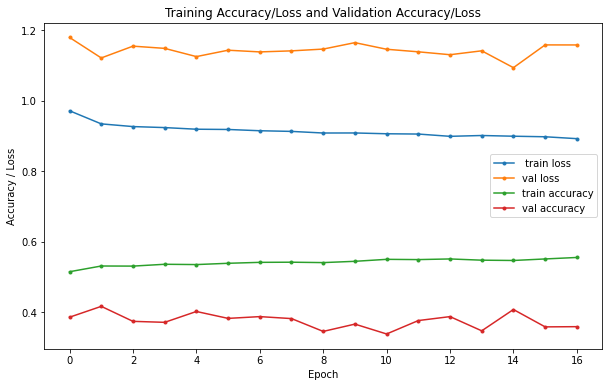

In [622]:
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'], marker='o', markersize = 3, label=' train loss')
plt.plot(history.history['val_loss'], marker='o', markersize = 3, label='val loss')
plt.plot(history.history['acc'], marker='o', markersize = 3, label='train accuracy')
plt.plot(history.history['val_acc'], marker='o', markersize = 3, label='val accuracy')
plt.title('Training Accuracy/Loss and Validation Accuracy/Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.show()

In [623]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

134/134 [==============================] - 0s 2ms/step - loss: 0.8829 - acc: 0.5688
Test Loss: 0.8828998804092407
Test Accuracy: 0.5688159465789795


In [624]:
predictions = model.predict(X_test)

pred_pitch = np.argmax(predictions,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)
xnames = pitch.columns


# Transform confusion matrix to df
cols = list(xnames)
for x in range(len(cols)):
    cols[x] = 'Pred_' + cols[x]
confusion_df = pd.DataFrame(confusion_matrix(actual_pitch,pred_pitch), columns=cols)
# Add column w/ sum of actuals
confusion_df['Sum of Actuals'] = confusion_df.sum(axis=1)
# Add row of sum of predictions
confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)
# Add detailed index names
indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]
indices.append('Sum of Predictions')
confusion_df.index=indices
confusion_df

,Pred_Breaking Ball,Pred_Fastball,Pred_Off-speed,Sum of Actuals
Actual_Breaking Ball,620,562,8,1190
Actual_Fastball,659,1787,32,2478
Actual_Off-speed,157,421,19,597
Sum of Predictions,1436,2770,59,4265


In [564]:
from sklearn.metrics import f1_score

f1_score(actual_pitch, pred_pitch, average = 'weighted')

0.493893097179775

In [630]:
from sklearn.metrics import classification_report

# Convert the array of integers into the pitch names using nested np.where functions
# For 2 pitch pitchers:
if max(actual_pitch) == 1:
    actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                            np.where(actual_pitch == 1, xnames.values[1], actual_pitch))

    pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                            np.where(pred_pitch == 1, xnames.values[1], pred_pitch))
elif max(actual_pitch) == 2:
    # For 3 pitch pitchers:
    actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                            np.where(actual_pitch == 1, xnames.values[1], 
                                     np.where(actual_pitch == 2, xnames.values[2], actual_pitch)))

    pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                            np.where(pred_pitch == 1, xnames.values[1], 
                                     np.where(pred_pitch == 2, xnames.values[2], pred_pitch)))
elif max(actual_pitch) == 3:
    # For 4 pitch pitchers:    
    actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                            np.where(actual_pitch == 1, xnames.values[1], 
                                     np.where(actual_pitch == 2, xnames.values[2], 
                                              np.where(actual_pitch == 3, xnames.values[3], actual_pitch))))

    pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                            np.where(pred_pitch == 1, xnames.values[1], 
                                     np.where(pred_pitch == 2, xnames.values[2], 
                                              np.where(pred_pitch == 3, xnames.values[3], pred_pitch))))


report_initial = classification_report(actual_pitch, pred_pitch)
print(report_initial)

               precision    recall  f1-score   support

Breaking Ball       0.43      0.52      0.47      1190
     Fastball       0.65      0.72      0.68      2478
    Off-speed       0.32      0.03      0.06       597

     accuracy                           0.57      4265
    macro avg       0.47      0.42      0.40      4265
 weighted avg       0.54      0.57      0.54      4265



In [475]:
model.save('saved_model/kershaw') 

INFO:tensorflow:Assets written to: saved_model/kershaw\assets


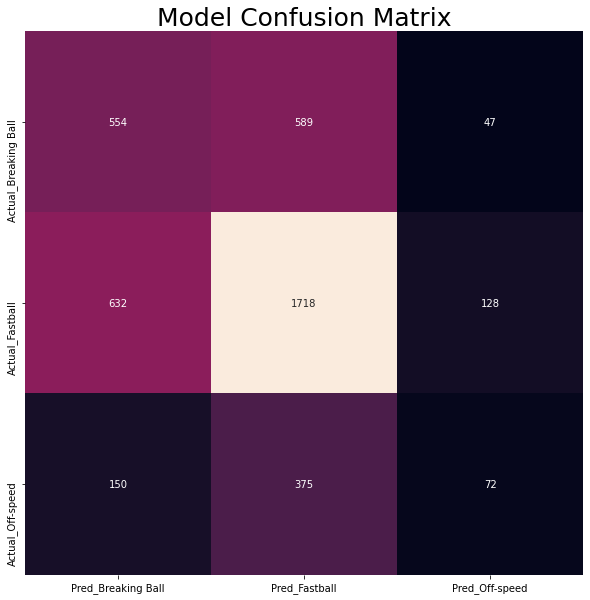

In [109]:
pred_pitch = np.argmax(predictions,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)
xnames = pitch.columns

indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]

conf_mat = confusion_matrix(actual_pitch,pred_pitch)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            xticklabels=cols,
            yticklabels=indices,
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

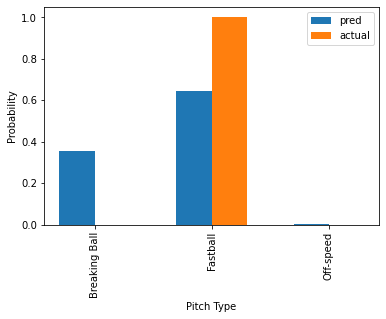

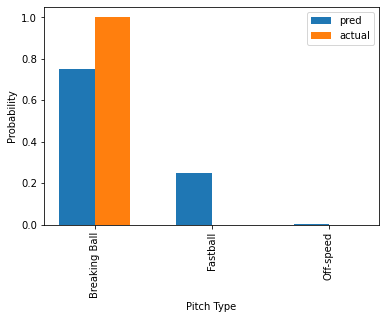

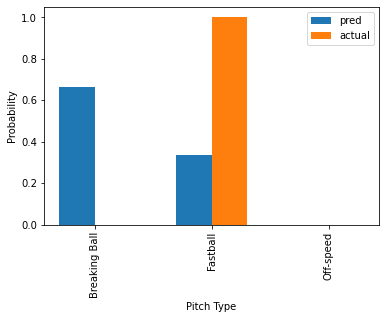

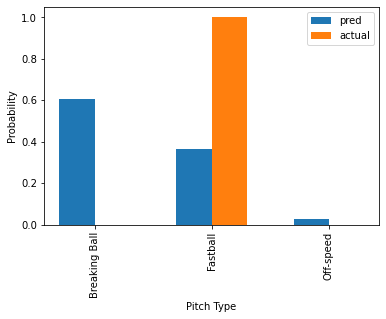

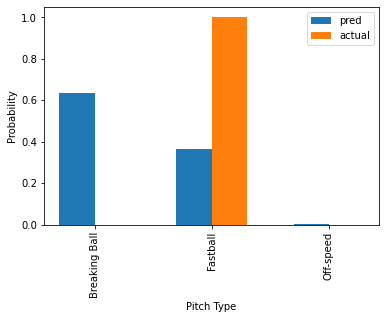

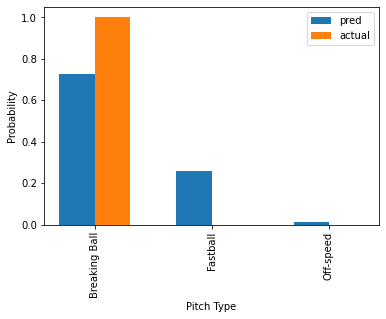

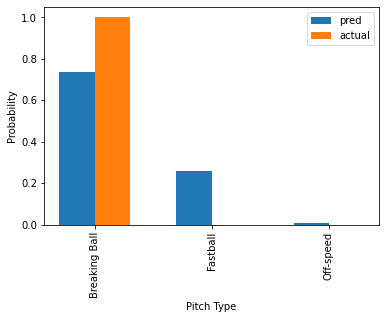

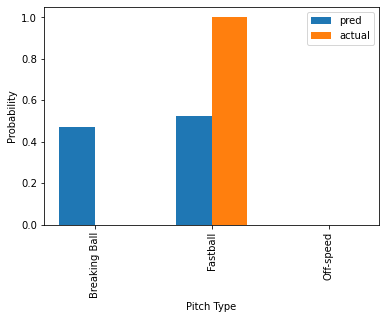

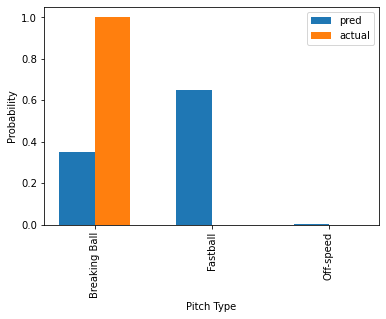

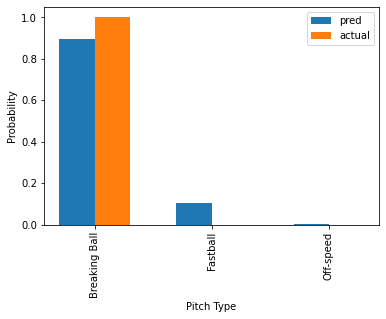

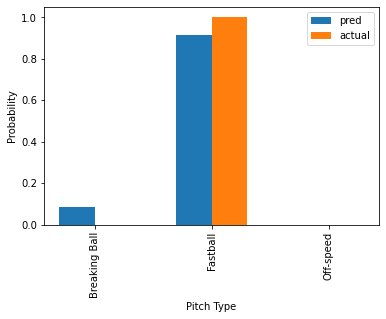

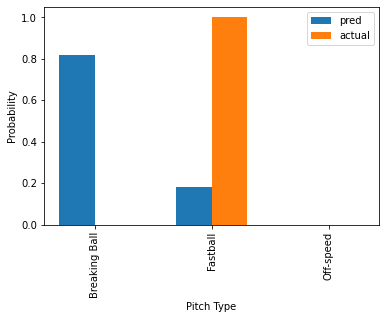

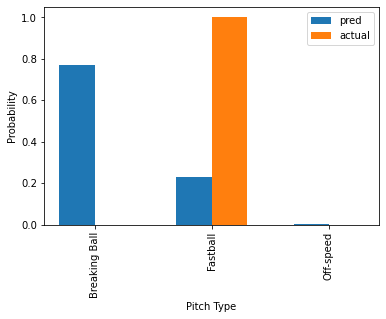

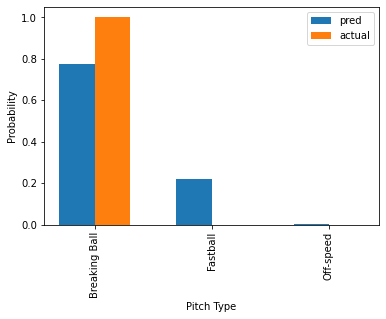

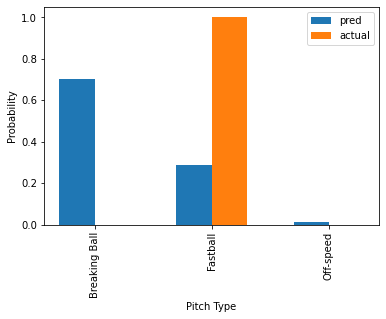

In [486]:
predictions = model.predict(X_test)

xnames = pitch.columns

indices = np.arange(len(pitch.columns))
width = 0.3

for i in np.arange(15):
    plt.bar(indices-width/2, predictions[i], width, label = 'pred')
    plt.bar(indices + width/2, y_test[i], width, label = 'actual')
    plt.ylabel('Probability')
    plt.xlabel('Pitch Type')
    plt.legend()
    plt.xticks(indices, xnames, rotation=90)
    plt.show()

In [354]:
# Create a new row that starts with all zeros and then fill it up later according to inputs
new_row = pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0, 0]], columns = X_train.columns)
# Save for later use when getting user inputs through Flask
new_row.to_csv('for_inputs.csv')

In [355]:
# Test to see if it can be written over
pd.options.display.max_columns = None
test = pd.read_csv('for_inputs.csv', index_col = 0)
test['s__0'] = 1
test

,on_3b,on_2b,on_1b,bat_score,fld_score,reg_season,post_season,bat_left,bat_right,b__0,b__1,b__2,b__3,s__0,s__1,s__2,o__0,o__1,o__2,prev__Breaking Ball,prev__Fastball,prev__None,prev__Off-speed,early,mid,late
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
### Upon further thought, this is not the best baseline indicator!
'''
fb = y_test.copy()

# Baseline accuracy if guess was ALL 4 seam fastball

# Equals a copy to not modify the original just in case
fb = y_test.copy()

# Make all elements an array that corresponds to 4S-FB
for i in range(len(fb)):
    fb[i] = np.array([0,1,0,0,0,0])

match = 0
for i in range(len(fb)):
    # Add 1 to match if the arrays correspond to 4S-FB
    if np.all(fb[i] == y_test[i]):
        match = match+1
        
# Accuracy score caluclated by matches/total
acc = match/len(fb)
acc
'''

---

In [144]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [631]:
# Need to use different types of y values for DTree (y is not an array)
y_pitch = df_downsampled['pitch_name']

In [149]:
# Instantiate decision tree w/o any parameters for now, set random state for consistency
tree = DecisionTreeClassifier(random_state=123)

# Set range of values
depth = np.arange(1, 21)
leafs = np.arange(1,10)

# Create dictionary of parameters
params = {'max_depth':depth, 'min_samples_leaf':leafs}

# Instatiate grid search using my tree model and my parameters, and 5 fold cross val
# Use ALL cores
grid = GridSearchCV(tree, params, cv=5, n_jobs = -1, verbose = 1)

# Fit grid to my training data
fittedgrid = grid.fit(X_train, y_pitch)

# Get best one
fittedgrid.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 885 out of 900 | elapsed:   12.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   12.7s finished


DecisionTreeClassifier(max_depth=1, random_state=123)

In [632]:
tree = DecisionTreeClassifier(max_depth = 3, random_state=123).fit(X_train, y_pitch)
tree.score(X_test, y_test_copy)

0.5453692848769051

In [633]:
y_pred = tree.predict(X_test)

y_pred_array = pd.get_dummies(y_pred).values

pred_pitch = np.argmax(y_pred_array,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)


actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                        np.where(actual_pitch == 1, xnames.values[1], 
                                 np.where(actual_pitch == 2, xnames.values[2], actual_pitch)))

pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                        np.where(pred_pitch == 1, xnames.values[1], 
                                 np.where(pred_pitch == 2, xnames.values[2], pred_pitch)))

In [634]:
report_initial = classification_report(actual_pitch, pred_pitch)
print(report_initial)

               precision    recall  f1-score   support

Breaking Ball       0.42      0.71      0.53      1190
     Fastball       0.66      0.60      0.63      2478
    Off-speed       0.00      0.00      0.00       597

     accuracy                           0.55      4265
    macro avg       0.36      0.44      0.38      4265
 weighted avg       0.50      0.55      0.51      4265



C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [635]:
cols = list(xnames)
for x in range(len(cols)):
    cols[x] = 'Pred_' + cols[x]
confusion_df = pd.DataFrame(confusion_matrix(actual_pitch,pred_pitch), columns=cols)
# Add column w/ sum of actuals
confusion_df['Sum of Actuals'] = confusion_df.sum(axis=1)
# Add row of sum of predictions
confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)
# Add detailed index names
indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]
indices.append('Sum of Predictions')
confusion_df.index=indices
confusion_df

,Pred_Breaking Ball,Pred_Fastball,Pred_Off-speed,Sum of Actuals
Actual_Breaking Ball,843,347,0,1190
Actual_Fastball,995,1483,0,2478
Actual_Off-speed,163,434,0,597
Sum of Predictions,2001,2264,0,4265


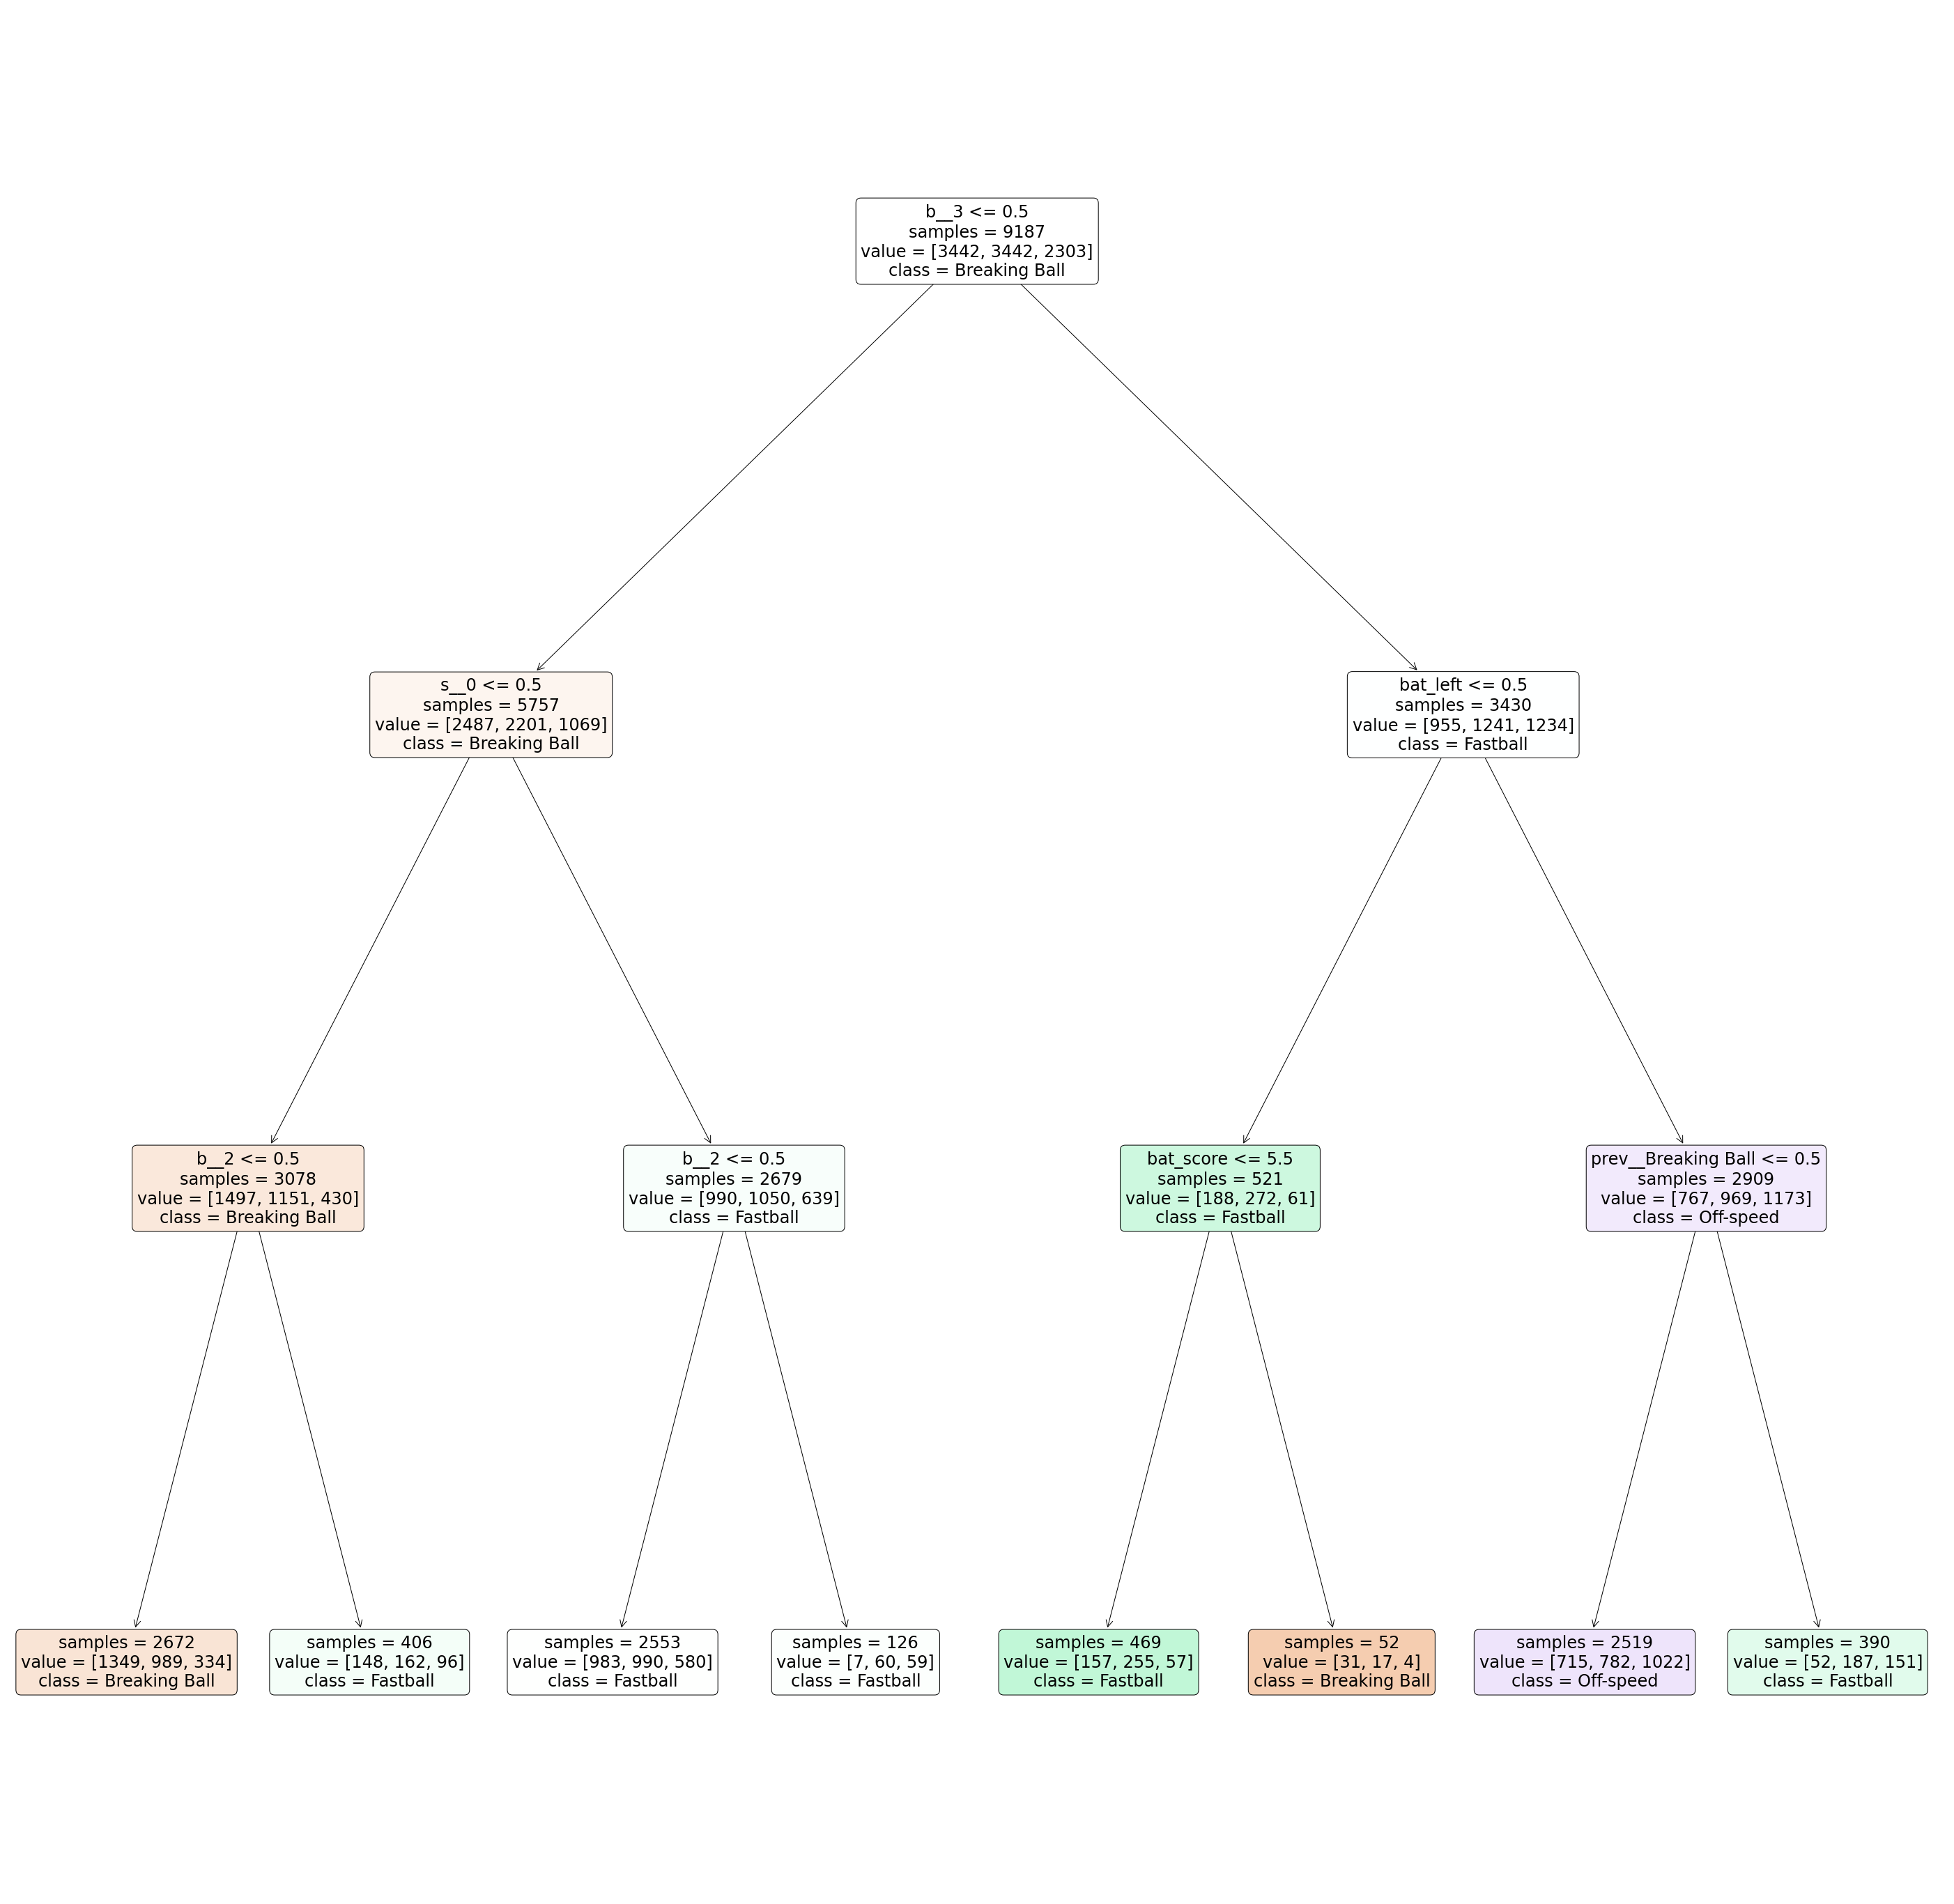

In [544]:
from sklearn.tree import plot_tree
plt.figure(figsize = (50, 50))
plot_tree(tree, 
          feature_names=X.columns, 
          class_names=xnames.values,
          rounded=True,
          impurity=False,
          filled=True)
plt.show()

***

In [153]:
from sklearn.linear_model import LogisticRegression

In [154]:
pens = ['l1', 'l2']
c_vals = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
logreg = LogisticRegression(solver = 'lbfgs')

params = {'C':c_vals, 'penalty':pens}

# Instatiate grid search using my tree model and my parameters, and 5 fold cross val
# Use ALL cores
grid = GridSearchCV(logreg, params, cv=5, n_jobs = -1, verbose = 1)

# Fit grid to my training data
fittedgrid = grid.fit(X_train, y_pitch)

# Get best one
fittedgrid.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 105 out of 120 | elapsed:    3.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.0s finished


LogisticRegression(C=0.001)

In [636]:
logit = LogisticRegression(C = 0.001, solver = 'lbfgs').fit(X_train, y_pitch)
logit.score(X_test, y_test_copy)

0.5441969519343494

In [637]:
y_pred = logit.predict(X_test)

y_pred_array = pd.get_dummies(y_pred).values

pred_pitch = np.argmax(y_pred_array,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)


actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                        np.where(actual_pitch == 1, xnames.values[1], 
                                 np.where(actual_pitch == 2, xnames.values[2], actual_pitch)))

pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                        np.where(pred_pitch == 1, xnames.values[1], 
                                 np.where(pred_pitch == 2, xnames.values[2], pred_pitch)))

In [638]:
report_initial = classification_report(actual_pitch, pred_pitch)
print(report_initial)

               precision    recall  f1-score   support

Breaking Ball       0.42      0.71      0.53      1190
     Fastball       0.66      0.59      0.62      2478
    Off-speed       0.31      0.01      0.03       597

     accuracy                           0.54      4265
    macro avg       0.46      0.44      0.39      4265
 weighted avg       0.54      0.54      0.51      4265



In [639]:
cols = list(xnames)
for x in range(len(cols)):
    cols[x] = 'Pred_' + cols[x]
confusion_df = pd.DataFrame(confusion_matrix(actual_pitch,pred_pitch), columns=cols)
# Add column w/ sum of actuals
confusion_df['Sum of Actuals'] = confusion_df.sum(axis=1)
# Add row of sum of predictions
confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)
# Add detailed index names
indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]
indices.append('Sum of Predictions')
confusion_df.index=indices
confusion_df

,Pred_Breaking Ball,Pred_Fastball,Pred_Off-speed,Sum of Actuals
Actual_Breaking Ball,840,346,4,1190
Actual_Fastball,991,1473,14,2478
Actual_Off-speed,163,426,8,597
Sum of Predictions,1994,2245,26,4265


***

## Summary

The CNN generally performs slightly better or on par compared to the logistic regression and decision trees in terms of accuracy. However, it consistently performs better when looking at the weighted F1 score across the classes as it is able to better predict the minority classes, which are generally Breaking Balls and Off Speed pitches.

Looking at the confusion matrices, the logistic regression performs very poorly in prediction the smallest minority class and therefore the bulk of its accuracy can be attributed to its high number of predictions for the more abundant classes.

The decision tree also suffers the same issue at times, while at other times, it's predictions are almost too evenly distributed across the minority classes, which does not reflect the real distribution.

In general, the CNN may perform only slightly better in terms of overall accuracy, but its predictions reflect the underlying uneven distribution of pitches in the test set and is therefore the more practical model.

***

## Creating CNNs for All Pitchers

In [640]:
# List of players to go through for now
player_list = ['Clayton Kershaw', 'Justin Verlander', 'Max Scherzer', 'Stephen Strasburg', 'Gerrit Cole',
              'Jacob deGrom', 'Zack Greinke', 'Madison Bumgarner', 'Marcus Stroman', 'Chris Sale', 'Hyun-Jin Ryu']

C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


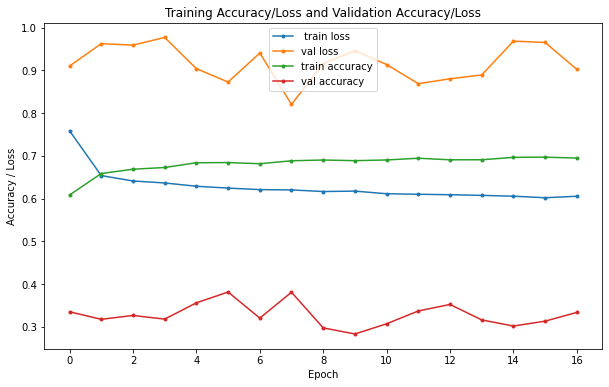

113/113 [==============================] - 0s 2ms/step - loss: 0.6786 - acc: 0.6154
Test Loss: 0.6785773634910583
Test Accuracy: 0.6153632998466492


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

Breaking Ball       0.58      0.90      0.71      1847
     Fastball       0.76      0.32      0.44      1742
    Off-speed       0.00      0.00      0.00        17

     accuracy                           0.62      3606
    macro avg       0.45      0.41      0.38      3606
 weighted avg       0.66      0.62      0.58      3606

INFO:tensorflow:Assets written to: saved_model/kershaw\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


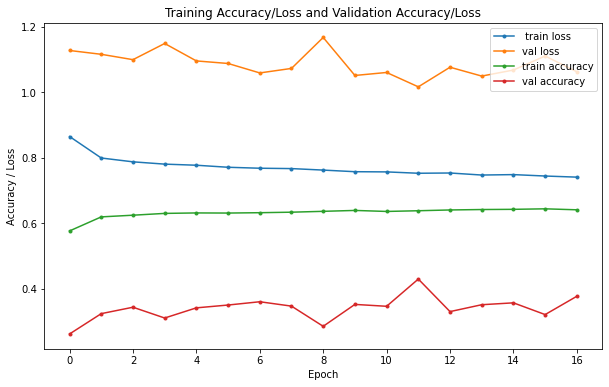

137/137 [==============================] - 0s 2ms/step - loss: 0.7671 - acc: 0.6255
Test Loss: 0.7671343088150024
Test Accuracy: 0.6254879236221313
               precision    recall  f1-score   support

Breaking Ball       0.57      0.42      0.48      1635
     Fastball       0.65      0.81      0.72      2500
    Off-speed       0.38      0.01      0.03       220

     accuracy                           0.63      4355
    macro avg       0.53      0.42      0.41      4355
 weighted avg       0.60      0.63      0.60      4355

INFO:tensorflow:Assets written to: saved_model/verlander\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


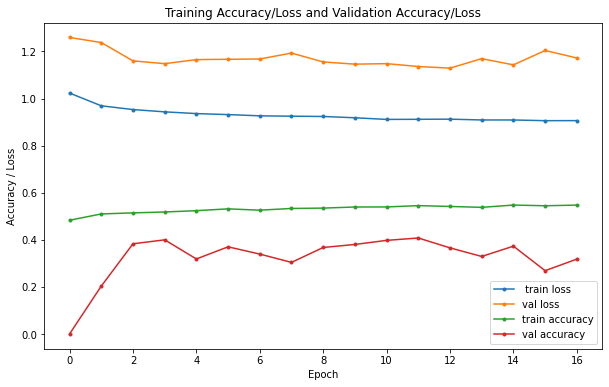

134/134 [==============================] - 0s 2ms/step - loss: 0.8766 - acc: 0.5747
Test Loss: 0.8766452074050903
Test Accuracy: 0.574677586555481
               precision    recall  f1-score   support

Breaking Ball       0.43      0.49      0.46      1190
     Fastball       0.64      0.75      0.69      2478
    Off-speed       0.39      0.01      0.02       597

     accuracy                           0.57      4265
    macro avg       0.49      0.42      0.39      4265
 weighted avg       0.55      0.57      0.53      4265

INFO:tensorflow:Assets written to: saved_model/scherzer\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


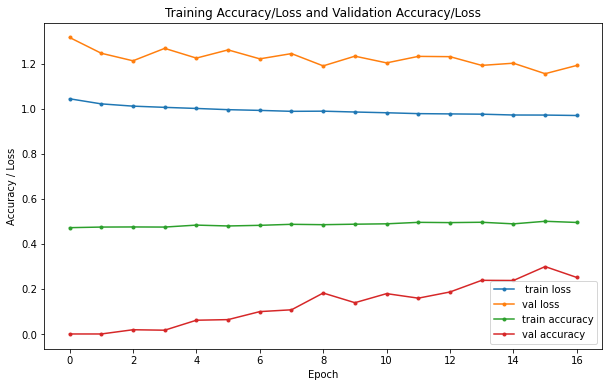

105/105 [==============================] - 0s 1ms/step - loss: 0.9655 - acc: 0.4898
Test Loss: 0.9655274748802185
Test Accuracy: 0.48981425166130066
               precision    recall  f1-score   support

Breaking Ball       0.32      0.24      0.28       948
     Fastball       0.58      0.71      0.64      1802
    Off-speed       0.31      0.22      0.26       588

     accuracy                           0.49      3338
    macro avg       0.40      0.39      0.39      3338
 weighted avg       0.46      0.49      0.47      3338

INFO:tensorflow:Assets written to: saved_model/strasburg\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


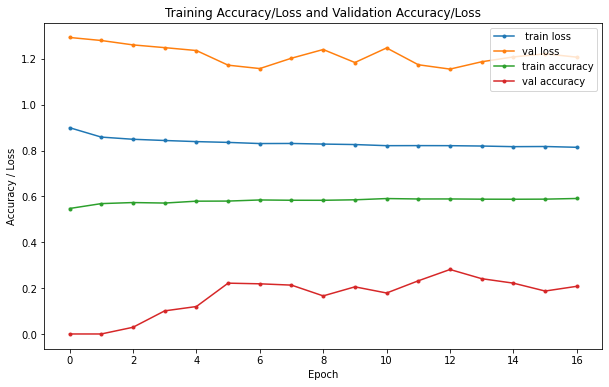

124/124 [==============================] - 0s 1ms/step - loss: 0.8062 - acc: 0.5888
Test Loss: 0.8062143921852112
Test Accuracy: 0.5888440012931824


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

Breaking Ball       0.44      0.23      0.30      1329
     Fastball       0.62      0.85      0.72      2381
    Off-speed       0.00      0.00      0.00       252

     accuracy                           0.59      3962
    macro avg       0.35      0.36      0.34      3962
 weighted avg       0.52      0.59      0.53      3962

INFO:tensorflow:Assets written to: saved_model/cole\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


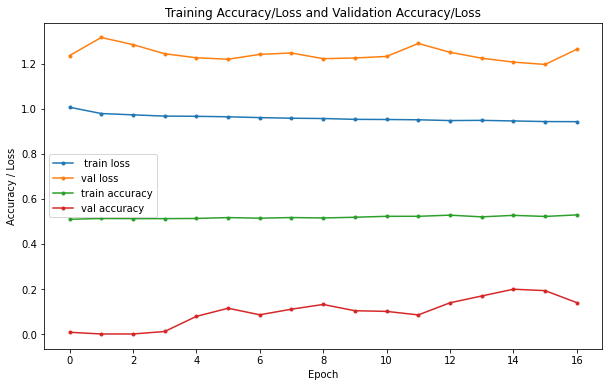

120/120 [==============================] - 0s 1ms/step - loss: 0.9418 - acc: 0.5406
Test Loss: 0.9418125152587891
Test Accuracy: 0.5406397581100464


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

Breaking Ball       0.38      0.20      0.26      1182
     Fastball       0.57      0.86      0.69      2121
    Off-speed       0.00      0.00      0.00       511

     accuracy                           0.54      3814
    macro avg       0.32      0.35      0.32      3814
 weighted avg       0.44      0.54      0.46      3814

INFO:tensorflow:Assets written to: saved_model/degrom\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


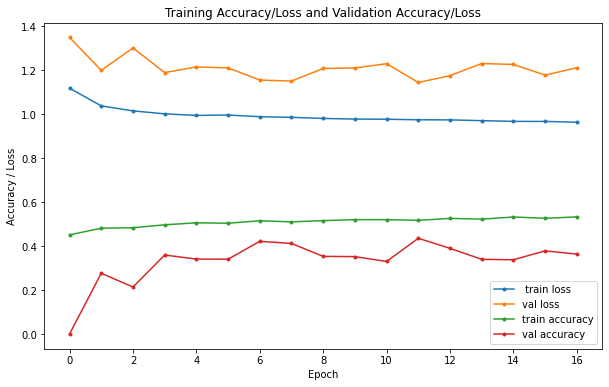

125/125 [==============================] - 0s 958us/step - loss: 0.9870 - acc: 0.5043
Test Loss: 0.9869505167007446
Test Accuracy: 0.5042713284492493


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

Breaking Ball       0.44      0.42      0.43      1227
     Fastball       0.55      0.67      0.60      1963
         Junk       0.00      0.00      0.00        34
    Off-speed       0.43      0.24      0.31       756

     accuracy                           0.50      3980
    macro avg       0.35      0.33      0.33      3980
 weighted avg       0.49      0.50      0.49      3980

INFO:tensorflow:Assets written to: saved_model/greinke\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


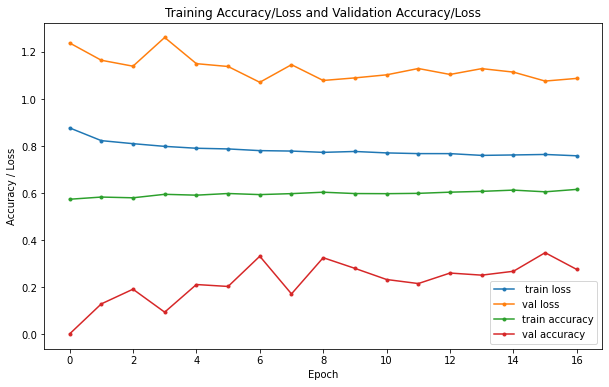

108/108 [==============================] - 0s 1ms/step - loss: 0.7564 - acc: 0.6061
Test Loss: 0.7563831210136414
Test Accuracy: 0.6060869693756104


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

Breaking Ball       0.44      0.31      0.37      1136
     Fastball       0.66      0.80      0.72      2158
    Off-speed       0.00      0.00      0.00       156

     accuracy                           0.61      3450
    macro avg       0.37      0.37      0.36      3450
 weighted avg       0.56      0.61      0.57      3450

INFO:tensorflow:Assets written to: saved_model/bumgarner\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


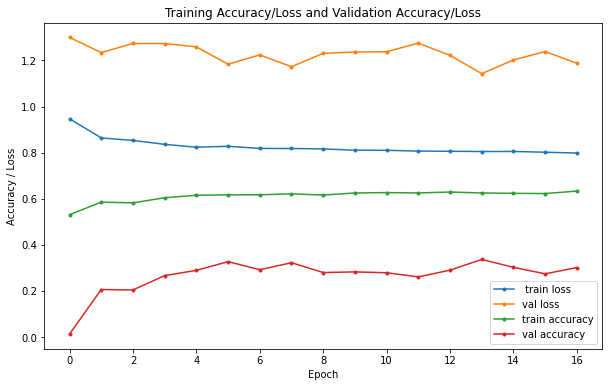

93/93 [==============================] - 0s 1ms/step - loss: 0.7525 - acc: 0.6818
Test Loss: 0.7525065541267395
Test Accuracy: 0.6818181872367859


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

Breaking Ball       0.48      0.39      0.43       799
     Fastball       0.74      0.86      0.79      1985
    Off-speed       0.00      0.00      0.00       164

     accuracy                           0.68      2948
    macro avg       0.41      0.41      0.41      2948
 weighted avg       0.63      0.68      0.65      2948

INFO:tensorflow:Assets written to: saved_model/stroman\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


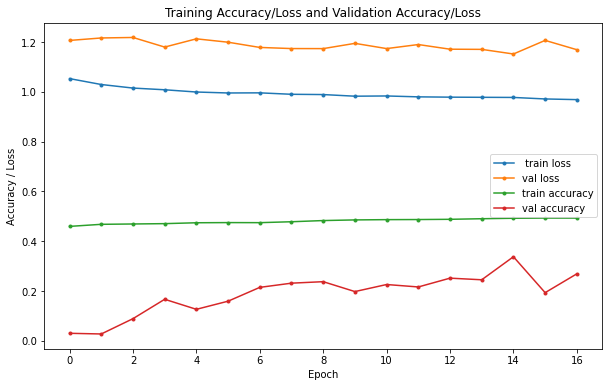

121/121 [==============================] - 0s 923us/step - loss: 0.9710 - acc: 0.4689
Test Loss: 0.9709935188293457
Test Accuracy: 0.46891191601753235
               precision    recall  f1-score   support

Breaking Ball       0.36      0.24      0.29      1148
     Fastball       0.53      0.68      0.60      1944
    Off-speed       0.36      0.27      0.31       768

     accuracy                           0.47      3860
    macro avg       0.42      0.40      0.40      3860
 weighted avg       0.44      0.47      0.45      3860

INFO:tensorflow:Assets written to: saved_model/sale\assets


C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


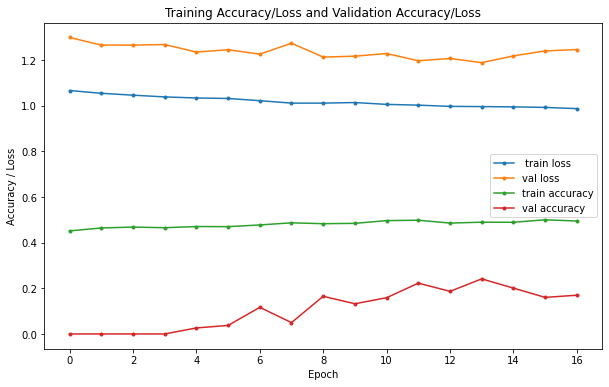

51/51 [==============================] - 0s 939us/step - loss: 0.9573 - acc: 0.5479
Test Loss: 0.9572868347167969
Test Accuracy: 0.547911524772644
               precision    recall  f1-score   support

Breaking Ball       0.41      0.04      0.08       270
     Fastball       0.61      0.80      0.69       958
    Off-speed       0.33      0.28      0.30       400

     accuracy                           0.55      1628
    macro avg       0.45      0.37      0.36      1628
 weighted avg       0.51      0.55      0.50      1628

INFO:tensorflow:Assets written to: saved_model/ryu\assets


In [644]:
for name in player_list:
    kershaw = df[df['player_name']==name]

    # Drop intentional balls and pitch outs, they aren't real pitches and batters don't need to worry about them
    kershaw.drop(kershaw[kershaw['pitch_name']=='Intentional Ball'].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['pitch_name']=='Pitch Out'].index, inplace=True, errors = 'ignore')
    kershaw.drop(kershaw[kershaw['pitch_name']=='Other'].index, inplace=True, errors = 'ignore')

    # Unable to classify/do regression with classes with only 1 instance
    # so drop the rows with that pitch as well as the row w/ corresponding 'prev_pitch'
    for i in range(len(kershaw['pitch_name'].value_counts())):
        if kershaw['pitch_name'].value_counts()[i] == 1:
            drop = kershaw['pitch_name'].value_counts().index[i]
            kershaw.drop(kershaw[kershaw['pitch_name']==drop].index, inplace=True)
            kershaw.drop(kershaw[kershaw['prev_pitch']==drop].index, inplace=True)

    kershaw.drop(['game_date', 'description'], axis = 1, inplace = True)

    # Don't need pitcher handedness in this, the variance of the columns will be 0
    kershaw.drop(['p_left', 'p_right'], axis = 1, inplace = True)

    # Drop release_speed since this isn't a predicative feature for guessing pitches prior to the pitch being thrown
    kershaw.drop(['release_speed'], axis = 1, inplace = True)

    # Drop other non pre-pitch predicative stuff
    kershaw.drop(['type', 'plate_x', 'plate_z'], axis = 1, inplace = True)

    kershaw.drop(['player_name', 'at_bat_number'], axis = 1, inplace = True)

    balls = pd.get_dummies(kershaw['balls'], prefix = 'b_')

    strikes = pd.get_dummies(kershaw['strikes'], prefix = 's_')

    prev = pd.get_dummies(kershaw['prev_pitch'], prefix= 'prev_')

    outs = pd.get_dummies(kershaw['outs_when_up'], prefix = 'o_')

    X = pd.concat([kershaw, balls, strikes, outs, prev], axis = 1)

    # Drop the original columns
    X.drop(['balls', 'strikes', 'outs_when_up', 'prev_pitch'], axis = 1, inplace = True)

    # X.drop(['pitch_name'], axis = 1, inplace = True)

    X.drop(['sz_top', 'sz_bot'], axis = 1, inplace = True)

    X['early'] = np.where(X['inning'] <= 3, 1, 0)
    X['mid'] = np.where((X['inning'] <= 6) & (X['inning'] > 3), 1, 0)
    X['late'] = np.where((X['inning'] <= 9) & (X['inning'] > 6), 1, 0)

    X.drop(['inning'], axis = 1, inplace = True)

    X.drop(['pitch_number'], axis = 1, inplace = True)

    X.drop(['zone'], axis = 1, inplace = True)

    X1 = X.drop(['pitch_name'], axis = 1)
    y = X['pitch_name']


    # Split with stratification given the class imbalance
    X_train, X_test, y_train, y_test = train_test_split(X1, y, stratify = y, test_size=0.25, random_state=123)
    y_test_copy = y_test.copy()

    train = pd.concat([X_train, y_train], axis =1)

    df_major =  train[train['pitch_name']==train['pitch_name'].value_counts().index[0]]
    df_rest = train[train['pitch_name']!=train['pitch_name'].value_counts().index[0]]

    df_down = resample(df_major, 
                          replace=True, 
                          n_samples = train['pitch_name'].value_counts().values[1], 
                          random_state=123)


    df_downsampled = pd.concat([df_down, df_rest])

    X_train = df_downsampled.drop(['pitch_name'], axis = 1)

    y_train = df_downsampled['pitch_name']

    # Convert output to an array
    pitch = pd.get_dummies(y_train.copy())
    y_train = pitch.values

    pitch = pd.get_dummies(y_test.copy())
    y_test = pitch.values

    # Best performing one so far
    opt = tf.keras.optimizers.Adam(lr=0.0001)

    # Make sure to reset model before running each time
    input_layer = Input(shape = (X_train.shape[1], ))
    dense_layer_1 = Dense(512, activation='relu')(input_layer)
    drop_layer_1 = tf.keras.layers.Dropout(.2)(dense_layer_1)
    dense_layer_2 = Dense(128, activation='relu')(drop_layer_1)
    drop_layer_2 = tf.keras.layers.Dropout(.2)(dense_layer_2)
    dense_layer_3 = Dense(128, activation='relu')(drop_layer_2)
    drop_layer_3 = tf.keras.layers.Dropout(.2)(dense_layer_3)
    dense_layer_4 = Dense(64, activation='relu')(drop_layer_3)
    # Output shape equals to number of classes (columns) in y
    output = Dense(y_train.shape[1], activation='softmax')(dense_layer_4)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

    history = model.fit(X_train, y_train, batch_size=25, epochs=17, verbose=0, validation_split=0.2)

    plt.figure(figsize = (10,6))
    plt.plot(history.history['loss'], marker='o', markersize = 3, label=' train loss')
    plt.plot(history.history['val_loss'], marker='o', markersize = 3, label='val loss')
    plt.plot(history.history['acc'], marker='o', markersize = 3, label='train accuracy')
    plt.plot(history.history['val_acc'], marker='o', markersize = 3, label='val accuracy')
    plt.title('Training Accuracy/Loss and Validation Accuracy/Loss')
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / Loss')
    plt.show()

    score = model.evaluate(X_test, y_test, verbose=1)
    print("Test Loss:", score[0])
    print("Test Accuracy:", score[1])
    
    predictions = model.predict(X_test)
    pred_pitch = np.argmax(predictions,axis=1)
    actual_pitch = np.argmax(y_test, axis = 1)
    xnames = pitch.columns

    # Convert the array of integers into the pitch names using nested np.where functions
    # For 2 pitch pitchers:
    if max(actual_pitch) == 1:
        actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                                np.where(actual_pitch == 1, xnames.values[1], actual_pitch))

        pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                                np.where(pred_pitch == 1, xnames.values[1], pred_pitch))
    elif max(actual_pitch) == 2:
        # For 3 pitch pitchers:
        actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                                np.where(actual_pitch == 1, xnames.values[1], 
                                         np.where(actual_pitch == 2, xnames.values[2], actual_pitch)))

        pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                                np.where(pred_pitch == 1, xnames.values[1], 
                                         np.where(pred_pitch == 2, xnames.values[2], pred_pitch)))
    elif max(actual_pitch) == 3:
        # For 4 pitch pitchers:    
        actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                                np.where(actual_pitch == 1, xnames.values[1], 
                                         np.where(actual_pitch == 2, xnames.values[2], 
                                                  np.where(actual_pitch == 3, xnames.values[3], actual_pitch))))

        pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                                np.where(pred_pitch == 1, xnames.values[1], 
                                         np.where(pred_pitch == 2, xnames.values[2], 
                                                  np.where(pred_pitch == 3, xnames.values[3], pred_pitch))))


    report_initial = classification_report(actual_pitch, pred_pitch)
    print(report_initial)

    lastname = name.split()[1].lower()
    model.save(f'saved_model/{lastname}') 